In [1]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import no_op, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images
from menpo.image import Image

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Define LSVM patch expert

Start by defining `centralize` and `normalize_norm` feature functions:

In [2]:
from menpo.feature import ndfeature

@ndfeature
def centralize(x, channels=True):
    if channels:
        m = np.mean(x, axis=(-2, -1))[..., None, None]
    else:
        m = np.mean(x)
    
    x = x - m
    
    return x


@ndfeature
def normalize_norm(x, channels=True):
    x = centralize(x, channels=channels)
    
    if channels:
        norm = np.asarray(np.linalg.norm(x, axis=(-2, -1))[..., None, None])
    else:
        norm = np.asarray(np.linalg.norm(x))
        
    if np.any(norm == 0):
        raise ValueError("Image has 0 variance - can't be normalized")
    else:
        x = x / norm
    
    return x

Linear Support Vector Machine (LSVM) patch expert:

In [3]:
from sklearn import svm
from menpofit.math.fft_utils import fft_convolve2d_bias_sum

class LSVMPatchExpert(object):
    r"""
    Linear Support Vector Machine patch expert
    """
    def __init__(self, normalize_callable=normalize_norm, **kwarg):
        self.normalize_callable = normalize_callable
        self.svm = svm.LinearSVC(class_weight='auto', **kwarg)

    def train(self, X, t):
        # number of samples, number of channels, height and width
        n, k, h, w = X.shape

        # for each sample
        keep = []
        count = 0
        for j, x in enumerate(X):
            try:
                # normalize it if required
                x = self.normalize_callable(x)
                X[count] = x
                keep.append(j)
                count += 1
            except:
                pass
        
        X = X[:count, ...]
        t = t[keep]

        X = X.reshape(n, -1)
        
        self.svm.fit(X, t)
        self.weights = self.svm.coef_.reshape((k, h, w))[:, ::-1, ::-1]
        self.bias = self.svm.intercept_
        
        return self

    @property
    def spatial_filter_image(self):
        return Image(self.weights[:, ::-1, ::-1])

    @property
    def frequency_filter_image(self):
        return Image(np.abs(fftshift(fft2(self.weights[:, ::-1, ::-1]))))

    def predict(self, x):
        # normalize if required
        x = self.normalize_callable(x)
        # compute svm response
        return fft_convolve2d_bias_sum(x, self.weights, self.bias)

## Load images

In [4]:
images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=100):
    if i.n_channels == 3:
        i = i.crop_to_landmarks_proportion(0.8)
        i = i.rescale_landmarks_to_diagonal_range(200)
        labeller(i, 'PTS', ibug_face_66)
        images.append(i)

Importing assets: [==========] 100% (100/100) - done.                           


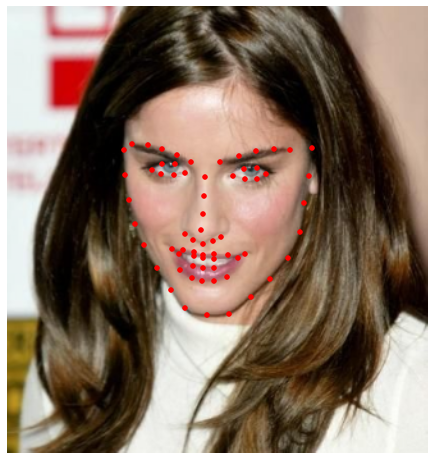

In [5]:
visualize_images(images)

In [6]:
shapes = [i.landmarks['ibug_face_66'].lms for i in images]

## Train a LSVM patch expert

In [7]:
def build_context_grid_mask(grid, positive_neighbourhood):
    positive_mask = np.zeros(grid.shape[:2], dtype=np.bool)
    centre = np.floor(np.asarray(positive_mask.shape) / 2)
    centre = np.require(centre, dtype=int)
    positive_neighbourhood = np.asarray(positive_neighbourhood) - 1
    start = centre - positive_neighbourhood
    end = centre + positive_neighbourhood
    positive_mask[start[0]:end[0]:1, start[1]:end[1]:1] = True
    return positive_mask

In [18]:
from menpo.shape import PointCloud
from menpofit.base import build_grid
from menpofit.clm.patch_experts import check_context_size

patch_size = (16, 16) 
context_size= 2
neighbourhood = (2, 2)
landmark = 42

# check parameters
context_size = check_context_size(context_size, patch_size)

# build grid
context_grid = build_grid(context_size)
# sample offsets
sample_offsets = PointCloud(context_grid.reshape((-1, 2)))
# labels
p_labels = build_context_grid_mask(context_grid, neighbourhood)

samples = []
labels = []
for (i, s) in zip(images, shapes):
    # choose appropriate landmark
    centre = PointCloud([s.points[landmark]])
    # extract positive sample
    p = i.extract_patches(centre, patch_size=patch_size,
                          sample_offsets=sample_offsets,
                          as_single_array=True)

    # append both patches and labels to their list
    samples.append(p[0])
    labels.append(p_labels.flatten())

samples = np.asarray(samples).reshape((-1,) + p.shape[2:])
labels = np.asarray(labels).flatten()

# turn list into ndarray
samples = np.asarray(samples)
# train patch experts
patch_expert = LSVMPatchExpert().train(samples, labels)

Visualize ideal response:

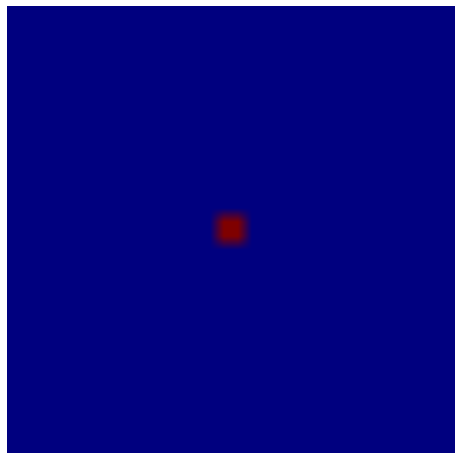

In [19]:
Image(p_labels).view(cmap_name='jet')

Visualize samples:

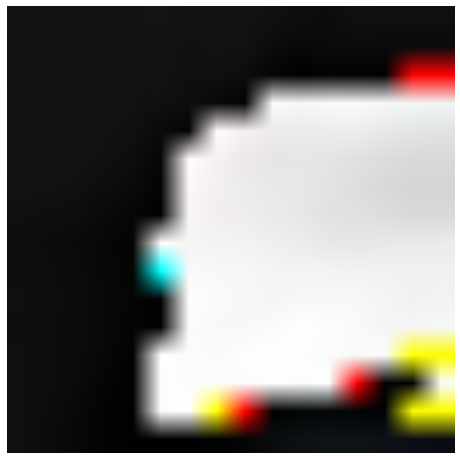

In [10]:
samples_images = [Image(s) for s in samples]

visualize_images(samples_images)

Visualize filters:

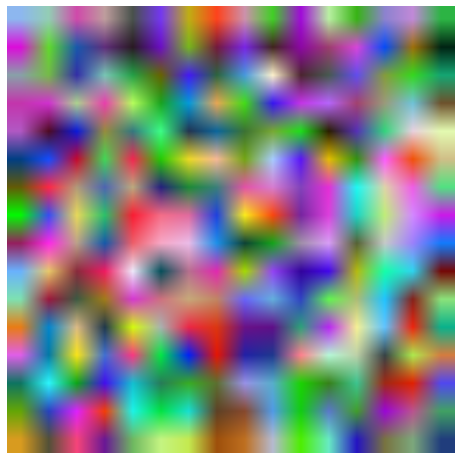

In [11]:
Image(patch_expert.weights).view_widget()

Visualize response on training patches:

In [12]:
# response_maps = [patch_expert.predict(Image(s)) for s in samples]

# visualize_images(response_maps)

Visualize responses:

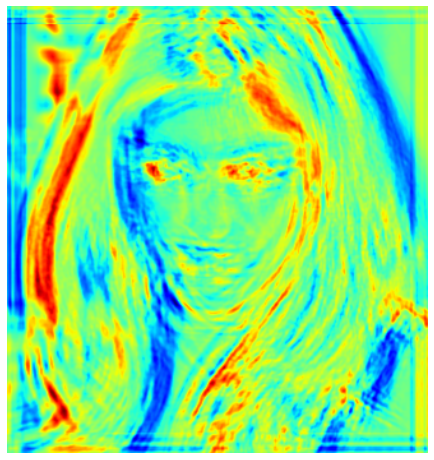

In [20]:
response_maps = [patch_expert.predict(i) for i in images]

visualize_images(response_maps)